## Gradient Inversion Attack

In [ ]:
%matplotlib inline

import numpy as np
from pprint import pprint

from skimage import io
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms



## Load the Dataset

In [ ]:
dst = datasets.MNIST("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2530592.95it/s]


Extracting /root/.torch/MNIST/raw/train-images-idx3-ubyte.gz to /root/.torch/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 232627.58it/s]


Extracting /root/.torch/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.torch/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4307968.12it/s]


Extracting /root/.torch/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.torch/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2583823.24it/s]

Extracting /root/.torch/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.torch/MNIST/raw



## Loss Function

In [ ]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

criterion = cross_entropy_for_onehot
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

### Neural Network Model

In [ ]:
class LeNet_5(nn.Module):
    def __init__(self, in_dims, in_channels, num_classes=10):
        super(LeNet_5, self).__init__()
        self.in_channels = in_channels
        self.input_size = int(np.sqrt(in_dims/in_channels))
        self.fc_input_size = int(self.input_size/4)**2 * 64

        self.conv1 = nn.Conv2d(self.in_channels, 32, kernel_size=5, padding=2)
        self.mp1= nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.mp2= nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(self.fc_input_size, 512, bias=False)
        self.fc2 = nn.Linear(512, num_classes, bias=False)

    # 32C3 - MP2 - 64C3 - Mp2 - 512FC - SM10c
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.mp1(x)

        x = F.relu(self.conv2(x))
        x = self.mp2(x)

        feature = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(feature))
        x = self.fc2(x)

        return x


model = LeNet_5(28*28, 1).to(device)

### Gradient Calculation on One Client (with One Sample)

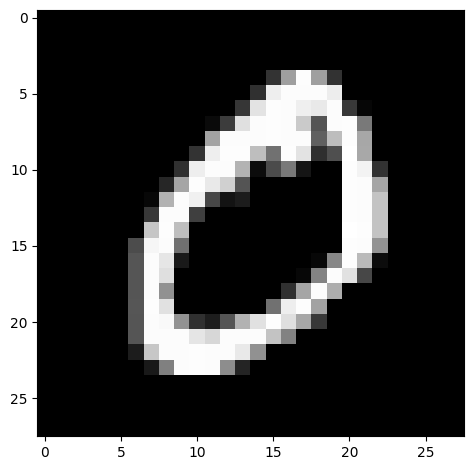

In [ ]:
index = 1
label = 0
input_data = tp(dst[index][0]).to(device)
input_data = input_data.view(1, 1, 28, 28)
input_label = torch.Tensor([dst[index][1]]).long().to(device)
gt_onehot_label = label_to_onehot(input_label)

img = input_data[0].cpu().reshape(28, 28)
io.imshow(img.numpy())

### Client Calculates Gradient

In [ ]:
out = model(input_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, model.parameters())

grad = list((_.detach().clone() for _ in dy_dx))

### Honest-but-curious Server

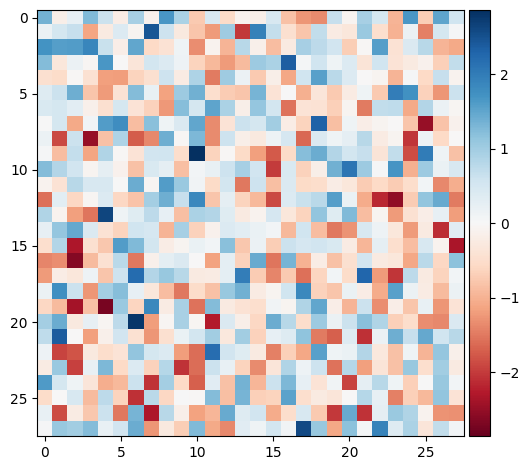

In [ ]:
dummy_data = torch.randn(input_data.size()).to(device).requires_grad_(True)

dummy_data_img = dummy_data.detach().cpu().numpy().reshape(28,28)
io.imshow(dummy_data_img)



### Server: Match Gradient

In [ ]:
optimizer = torch.optim.LBFGS([dummy_data])
# optimizer = torch.optim.Adam([dummy_data])

history = []
for iters in range(8):
    history.append(dummy_data[0].cpu())
    def closure():
        optimizer.zero_grad()

        pred = model(dummy_data)
        # dummy_onehot_label = F.softmax(model, dim=-1)
        onehot_label = label_to_onehot(torch.Tensor([label]).long().to(device), num_classes=10)
        dummy_loss = criterion(pred, onehot_label)
        dummy_grad = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_grad, grad):
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()

        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)

    if iters % 1 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())





0 0.2140
1 0.1205
2 0.0549
3 0.0270
4 0.0110
5 0.0277
6 0.0280
7 0.0280


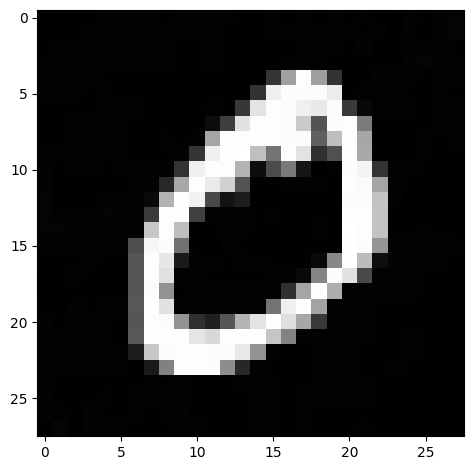

In [ ]:
iter_idx = 2
dummy_img = history[iter_idx].detach().cpu().numpy().reshape(28,28)
dummy_img = (dummy_img - dummy_img.min())/(dummy_img.max() - dummy_img.min())
io.imshow(dummy_img)

### Add noise to the client gradient

0 4158.9058
1 4158.9082
2 4158.3687
3 4158.1670
4 4158.2354
5 4158.2261
6 4158.2231
7 4158.2666


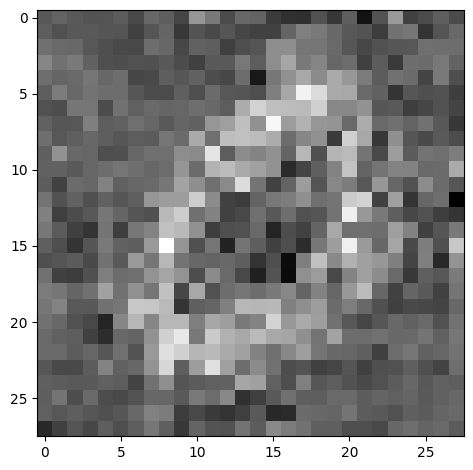

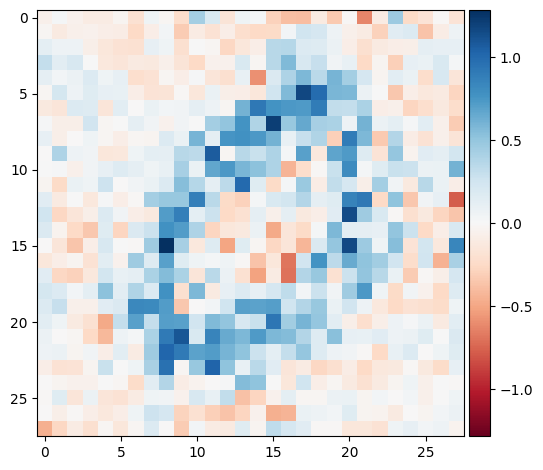

In [ ]:
noisy_grad = []

for i, g in enumerate(grad):
    noisy_grad.append(g + 0.05*torch.randn_like(g))

dummy_data = torch.randn(input_data.size()).to(device).requires_grad_(True)


optimizer = torch.optim.LBFGS([dummy_data])
# optimizer = torch.optim.Adam([dummy_data])

history = []
for iters in range(8):
    history.append(dummy_data[0].cpu())
    def closure():
        optimizer.zero_grad()

        pred = model(dummy_data)
        # dummy_onehot_label = F.softmax(model, dim=-1)
        onehot_label = label_to_onehot(torch.Tensor([label]).long().to(device), num_classes=10)
        dummy_loss = criterion(pred, onehot_label)
        dummy_grad = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0

        # now matching the noisy gradients
        for gx, gy in zip(dummy_grad, noisy_grad):
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()

        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)

    if iters % 1 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())

iter_idx = -1
dummy_img = history[iter_idx].detach().cpu().numpy().reshape(28,28)
dummy_img = (dummy_img - dummy_img.min())/(dummy_img.max() - dummy_img.min())
io.imshow(dummy_img)

plt.figure(2)
io.imshow(history[iter_idx].detach().cpu().numpy().reshape(28,28))